# Setup

## Imports & Settings

In [7]:
%load_ext autoreload
%autoreload 2

import os
import re
import itertools
import functools
import scipy
import scanpy as sc
import seaborn as sb
import pandas as pd
import numpy as np
import corescpy as cr

# Computing Resources
gpu = False
sc.settings.n_jobs = 8
# sc.settings.max_memory = 150

# Display
pd.options.display.max_colwidth = 1000
pd.options.display.max_columns = 100
pd.options.display.max_rows = 500
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(20, 20))

full_object = False  # False = faster; True = more features

# Panel & Column Names (from Metadata & To Be Created)
panel = "TUQ97N"
capitalize_sample = True if panel == "TUQ97N" else False
# panel = "XR4UZH"
suffix = ""  # if main objects (<sample><_region if applicable>.h5ad)
# suffix = "_new"  # example suffix for object h5ad file (to avoid overwrite)

# Samples/Runs
run = None  # just look for samples in all Xenium runs for the panel
# run = "CHO-001"  # run all from this run; so don't have to specify samples
samples = "all"  # use samples = "all" with run = something for all from run
# samples = ["50006B"]

# For Main Objects
# sub_dir_parent = None
# sub_dirs = [None]  # if no sub-directory; top level of

# For Regional/Object Sub-Directory Analyses
sub_dir_parent = "objects_cropped"
sub_dirs = ["mucosa", "submucosa", "myenteric_plexus", "smc_circular",
            "smc_longitudinal", "serosa"]  # if objects in sub-directories

# Object Files: Suffixes on Sample ID = Subdirectories or Single Suffix or ""
suffixes = [f"_{x}{suffix}" if x else f"{suffix}" for x in sub_dirs]

# Genes of Interest
genes = {
    "CD Risk": ["LACC1", "LRRK2", "PTGER4"],
    "SnC Marker": ["CDKN2A", "CDKN1A", "TP53", "PLAUR"],
    "Apoptosis-Resistance": ["BCL2"],
    "SASP": ["IL4", "IL13", "IL1A", "CXCL8", "CCL2", "CEBPB", "NFKB1",
             "TGFB1", "IGFBP7"],
    "SASP-IL6": ["OSM", "IL6", "IL6ST"],
    "Fibrosis": ["SUCNR1", "CXCR4", "IL33", "IL23A",
                 "IL1B", "IL12", "IL17", "IL36", "TL1A", "IL11", "IFNG",
                 "IL22", "IL10", "IL21", "IL34", "CCL11"],
    "ER Stress/UPR": ["ATF4"],
    "Autophagy": ["MTOR", "ATG3", "ATG5", "ATG7", "ATG12", "ATG16L1", "SQSTM1",
                  "BECN1", "IRGM1", "ATG8", "ATG6"],
    "DNA Repair": ["ERCC1", "ERCC4"],
    "Healing": ["LCN2", "MMP9", "GREM1", "PDGFRA"],
    "Mixed": ["ICAM1"]
}   # genes of interest: can just specify list of genes
genes_dict_colors = [
    "#FF0000", "#0000FF", "#000000", "#FFFF00", "#D2B48C",
    "#FFC0CB", "#A52A2A", "#800080", "#008000", "#808080"
] if isinstance(genes, dict) else None  # colors for each "key" of genes dict

# Main Directories
usr_write_rel_path = f"{os.getlogin()}/data/shared-xenium-library"
d_hpc = "/mnt/cho_lab" if os.path.exists(
    "/mnt/cho_lab") else "/sc/arion/projects/untreatedIBD"  # HPC path
d_nfs = os.path.join(d_hpc, "bbdata2") if os.path.exists(os.path.join(
    d_hpc, "bbdata2")) else os.path.join(
        d_hpc, "chobiolab-core/shared-xenium-library")
d_usr = os.path.join(d_hpc, "disk2", usr_write_rel_path) if os.path.exists(
    os.path.join(d_hpc, "disk2")) else os.path.join(d_hpc, usr_write_rel_path)
d_obj = d_usr  # CHANGE IF WRITING & PULLING OBJECTS FROM DIFFERENT PATHS
d_img = os.path.join(d_hpc, f"cache/tissue-registry/xenium/{panel}") if (
    "arion" in d_hpc) else os.path.join(d_hpc, f"bbdata1/xenium/{panel}")

# Construct Directories (Less Likely to Need Changes)
# Mirror my file/directory tree in the `d_usr` directory
obj_ext = ".h5ad"  # extension for processed objects
out_subdir_markers = "find_markers"  # sub-directory under out_dir for markers
out_obj = os.path.join(d_obj, f"outputs/{panel}/nebraska")
out_dir = os.path.join(d_usr, f"outputs/{panel}/nebraska")  # to save objects
out_plot = None if out_dir is None else os.path.join(
    out_dir, "plots")  # plot output directory
file_mdf = os.path.join(d_usr, f"samples_{panel}.csv")  # metadata file path
file_a = None  # don't map manual annotations
file_a = os.path.join(out_dir, "annotation_dictionaries/annotations_all.xlsx")
print(f"\n\n\n{'=' * 80}\nDirectories\n{'=' * 80}\n\nHPC Entry Point (Cho): "
      f"{d_hpc}\nData: {d_nfs}\nMetadata: {file_mdf}\nImages: {d_img}\n"
      f"Object/Outputs:\n\t{out_dir} (objects)\n\t{out_plot} (plots)\n\t"
      f"{os.path.join(out_dir, out_subdir_markers)} (markers)\n"
      f"Annotations: {file_a}\n\n\n")

# Leiden Column & Manual Annotation Mapping Options
col_leiden = f"leiden_res1pt5_dist0_npc30"
col_assignment = "bucket"  # column in annotation file whose labels to use
col_cluster = col_leiden if file_a is None else col_assignment
# col_assignment = "annotation"  # more specific cell types
suffix_ct = f"_{col_leiden}" + str(f"_{col_cluster}" if (
    col_cluster != col_leiden) else "")  # new out file suffix ~ cell type

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



Directories

HPC Entry Point (Cho): /mnt/cho_lab
Data: /mnt/cho_lab/bbdata2
Metadata: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/samples_TUQ97N.csv
Images: /mnt/cho_lab/bbdata1/xenium/TUQ97N
Object/Outputs:
	/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska (objects)
	/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/plots (plots)
	/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/find_markers (markers)
Annotations: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/annotation_dictionaries/annotations_all.xlsx





## Setup

Get constants (e.g., column names in metadata), read metadata, create dictionary of clustering parameters (so can iterate across different clustering specifications to make multiple versions, e.g., at multiple resolutions) using `res_list`, `min_dist_list`, and `n_comps_list`, make any output directories (e.g., for processed objects, plots, find markers results, Xenium Explorer cluster files) if any don't exist yet, load data into objects, etc.

In [8]:
# Get/Set Constants
constants_dict = cr.get_panel_constants(panel_id=panel)
col_sample_id_o, col_sample_id, col_condition, col_inflamed, col_subject = [
    constants_dict[x] if x in constants_dict else None for x in [
        "col_sample_id_o", "col_sample_id", "col_condition",
        "col_inflamed", "col_subject"]]
col_stricture, key_stricture, col_f, col_tangram, col_segment, col_object = [
    constants_dict[x] if (x in constants_dict) else None for x in [
        "col_stricture", "key_stricture", "col_data_dir",
        "col_tangram", "col_segment", "col_object"]]

# Read Metadata
metadata = cr.pp.get_metadata_cho(
    d_nfs, file_mdf, panel_id=panel, samples=samples, run=run,
    capitalize_sample=capitalize_sample)  # get metadata
print("\n\n", metadata[list(set([
    col_sample_id_o, col_subject, col_condition, col_inflamed, col_stricture,
    col_segment]).intersection(metadata))])

# Annotation File
f_ann = pd.read_excel(file_a, index_col=[0, 1]).dropna(how="all").dropna(
    how="all", axis=1)
f_ann = f_ann.reset_index().astype({f_ann.index.names[1]: "int"}).astype({
    f_ann.index.names[1]: "string"}).set_index(f_ann.index.names)

# Final Setup
if out_plot is not None:
    os.makedirs(out_plot, exist_ok=True)  # ensure plot save path exists
kws_init = dict(col_sample_id=col_sample_id, col_subject=col_subject,
                col_cell_type=col_cluster)



                    inflammation   Condition sample_id stricture  subject_id
Sample                                                                     
Uninflamed-50403A2   uninflamed  uninflamed   50403A2        no       50403
Uninflamed-50403A1   uninflamed  uninflamed   50403A1        no       50403
Uninflamed-50336C    uninflamed  uninflamed    50336C        no       50336
Inflamed-50336B        inflamed    inflamed    50336B        no       50336
Stricture-50336A       inflamed   stricture    50336A       yes       50336
Stricture-50403C2      inflamed   stricture   50403C2       yes       50403
Stricture-50403C1      inflamed   stricture   50403C1       yes       50403
Inflamed-50403B        inflamed    inflamed    50403B        no       50403
Stricture-50217C       inflamed   stricture    50217C       yes       50217
Uninflamed-50217B    uninflamed  uninflamed    50217B        no       50217
Inflamed-50217A        inflamed    inflamed    50217A        no       50217
Stricture

# Describe

Number of cells per region.

In [11]:
n_cells = {}
for r, sub_d in zip(suffixes, sub_dirs):  # loop sub-directories (or just top)
    out_r = str(os.path.join(out_plot, sub_d) if (
        sub_d) else out_plot) if out_plot else None  # plot directory
    in_r = os.path.join(out_obj, sub_dir_parent) if (
        sub_dir_parent) else out_obj  # object directory
    in_r = os.path.join(in_r, sub_d) if sub_d else in_r  # sub-directory?
    n_cells[r] = {}

    # Iterate Samples
    for x in metadata.index.values:
        print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}\n\n")
        out = os.path.join(in_r, f"{x}{r}{obj_ext}")
        if not os.path.exists(out):
            print(f"Skipping {x}: {out} doesn't exist!")
            n_cells[r][x] = np.nan
        else:
            n_cells[r][x] = sc.read_h5ad(out).obs.shape[0]



Uninflamed-50403A2




Uninflamed-50403A1


Skipping Uninflamed-50403A1: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/objects_cropped/mucosa/Uninflamed-50403A1_mucosa.h5ad doesn't exist!


Uninflamed-50336C




Inflamed-50336B




Stricture-50336A


Skipping Stricture-50336A: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/objects_cropped/mucosa/Stricture-50336A_mucosa.h5ad doesn't exist!


Stricture-50403C2


Skipping Stricture-50403C2: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/objects_cropped/mucosa/Stricture-50403C2_mucosa.h5ad doesn't exist!


Stricture-50403C1


Skipping Stricture-50403C1: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/objects_cropped/mucosa/Stricture-50403C1_mucosa.h5ad doesn't exist!


Inflamed-50403B




Stricture-50217C


Skipping Stricture-50217C: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebr

# Analyze

The first clustering version (first specified in `res_list`) is the cell type column used by default in downstream analyses (because it was specified in `kws_init["col_cell_type"]` when creating the object and thus is stored in `self._columns["col_cell_type"]`). Specify `col_cell_type` as an argument in the following functions to use a different column.



Uninflamed-50403A2




<<< INITIALIZING SPATIAL CLASS OBJECT >>>



Counts: Initial: table


	Observations: 115484

	Genes: 469

     n_cells_by_counts  mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
25%             5431.0     0.031646           0.031156              82.204565   
50%            17544.0     0.112692           0.106782              91.751569   
75%            37850.0     0.262282           0.232921              97.446578   

     total_counts  log1p_total_counts  n_cells  n_counts     means  \
25%        6731.0            8.814628   5337.0    6708.0  1.414975   
50%       23969.0           10.084558  17351.0   23855.0  2.431025   
75%       55786.0           10.929296  37628.0   55565.0  3.213856   

     dispersions  dispersions_norm      mean       std  
25%     5.000567         -0.677569  0.120875  0.733199  
50%     5.153704         -0.276739  0.391976  1.288292  
75%     5.412368          0.456446  0.852908  1.818271  






 AnnData object with n_obs × 

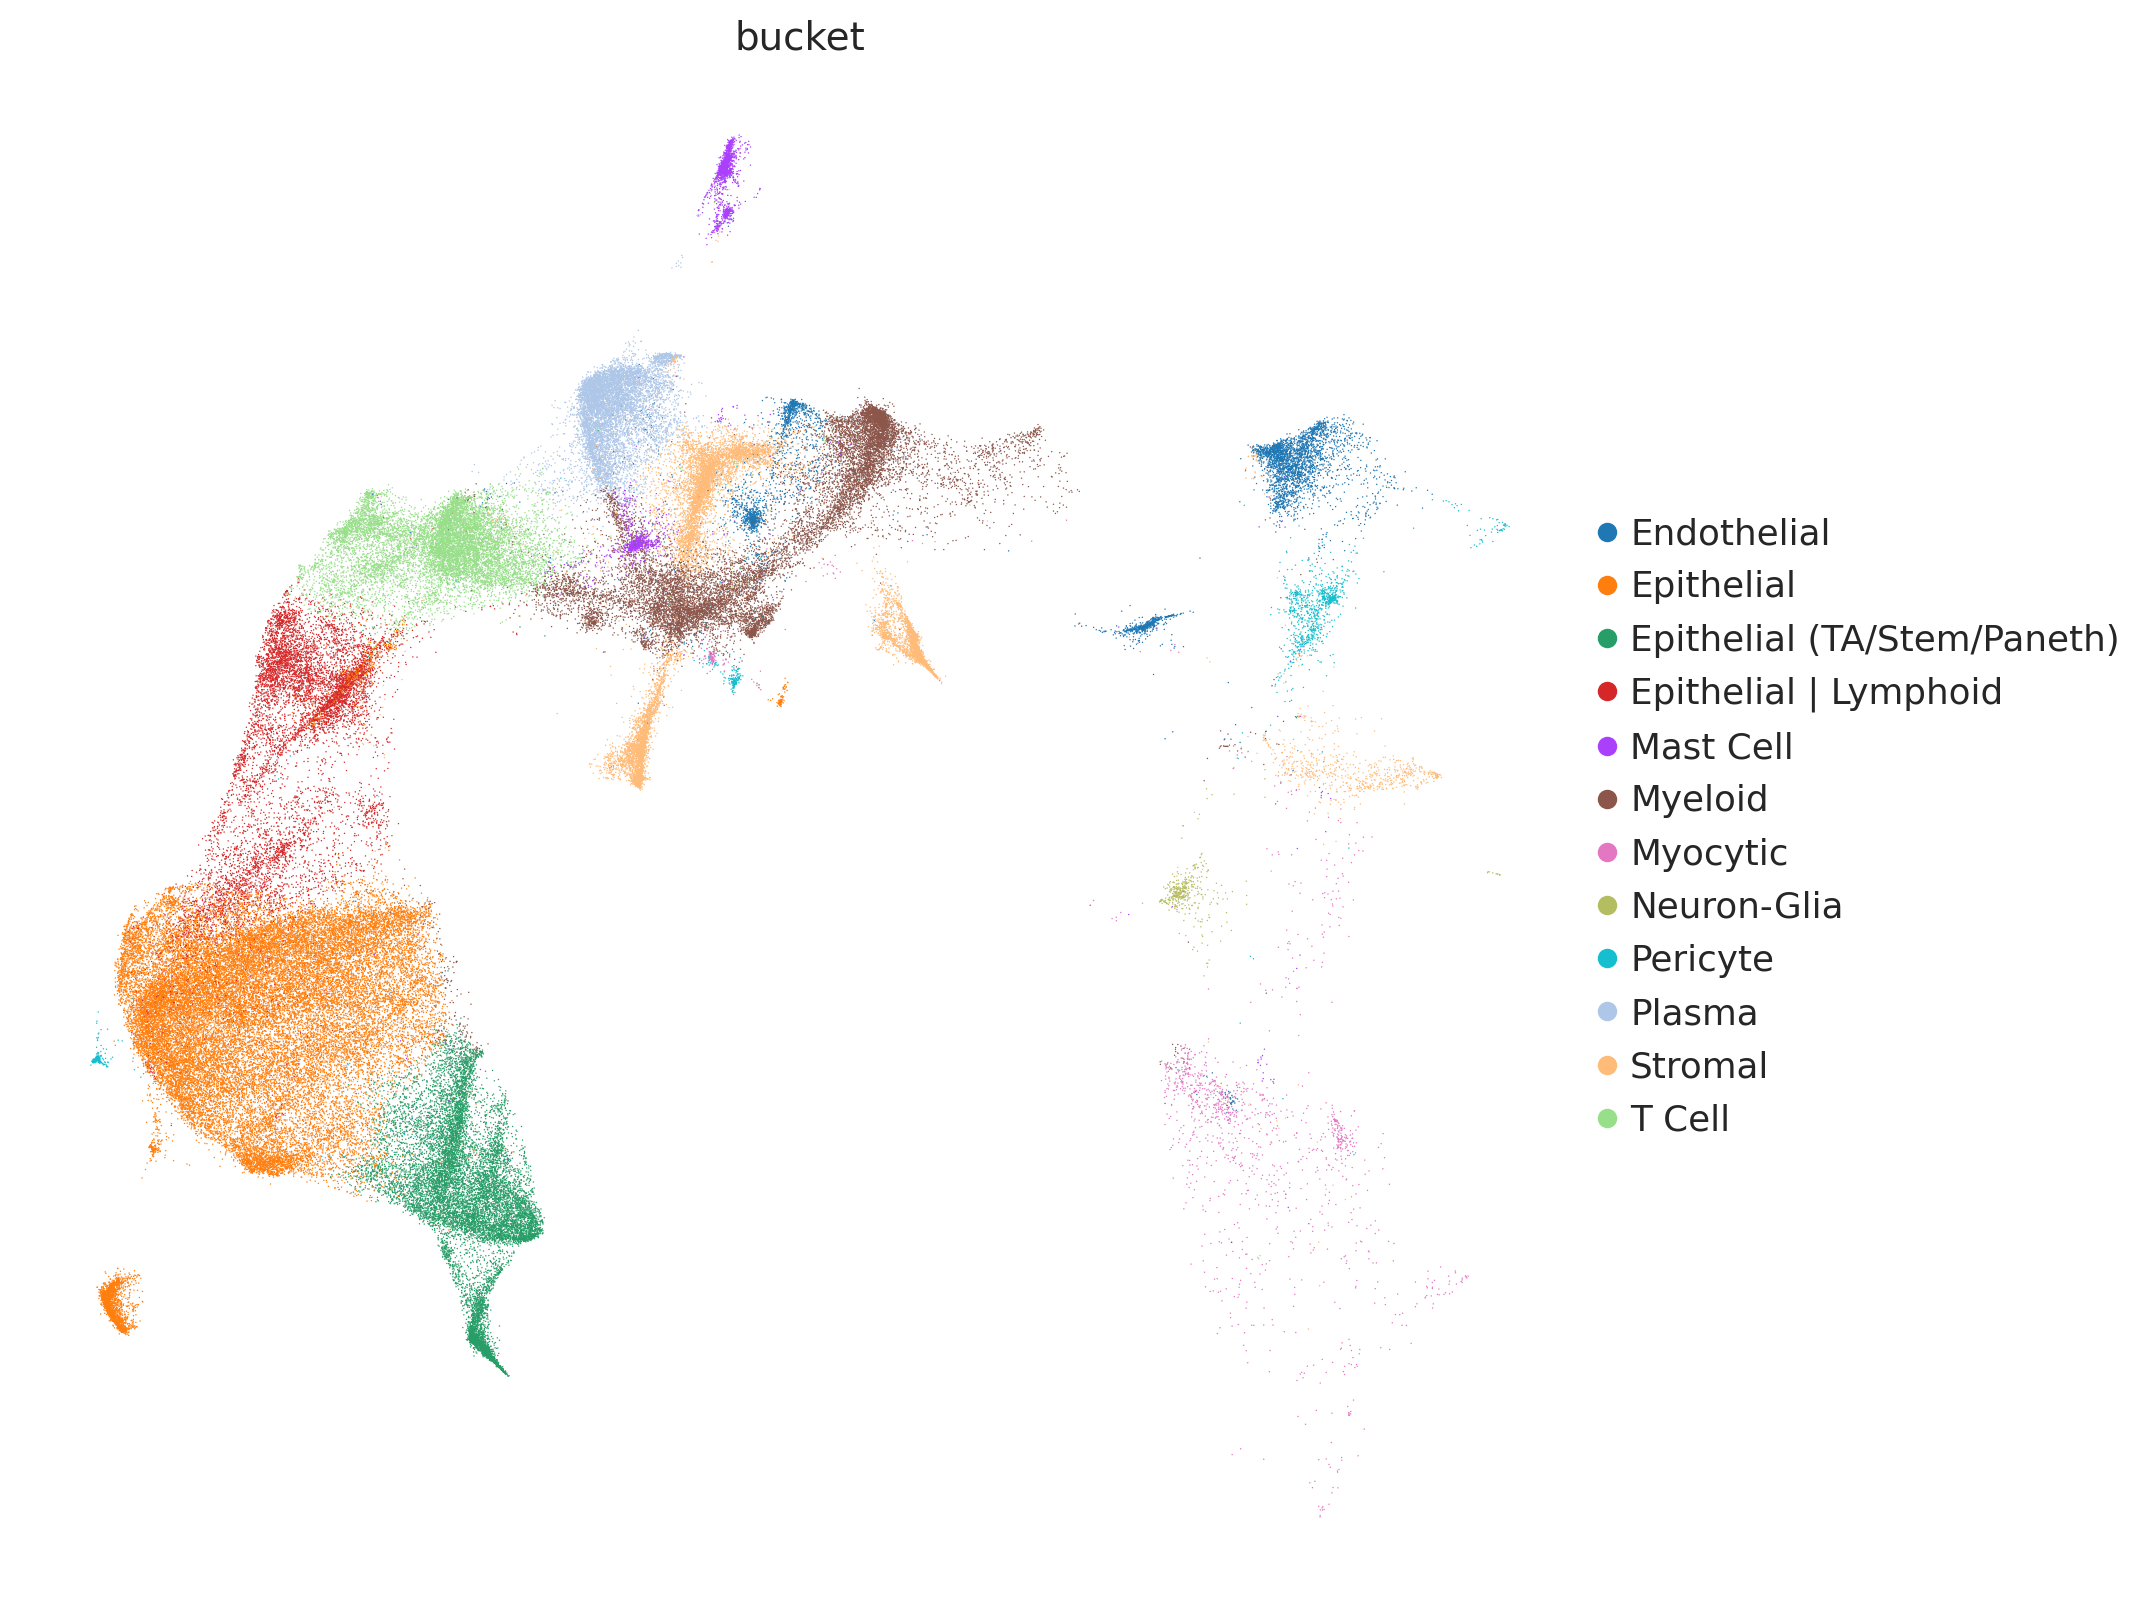

	*** Building connectivity matrix...


In [9]:
%%time

# Iterate Regions
for r, sub_d in zip(suffixes, sub_dirs):  # loop sub-directories (or just top)
    fig_central, fig_neigh, fig_cooccur, fig_svg = {}, {}, {}, {}
    fig_gex = {"heat": {}, "dot": {}}
    out_r = str(os.path.join(out_plot, sub_d) if (
        sub_d) else out_plot) if out_plot else None  # plot directory
    in_r = os.path.join(out_obj, sub_dir_parent) if (
        sub_dir_parent) else out_obj  # object directory
    in_r = os.path.join(in_r, sub_d) if sub_d else in_r  # sub-directory?
    if out_plot is not None:
        os.makedirs(out_r, exist_ok=True)

    # Iterate Samples
    for x in metadata.index.values:
        print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}\n\n")
        # if os.path.exists(os.path.join(out_r, re.sub(
        #     "/", "",f"gex_heat_{x}{r}{suffix_ct}_{'_'.join(genes)}.jpeg"))):
        #     print("Already exists: " + os.path.join(out_r, re.sub(
        #                 "/", "",f"gex_heat_{x}{r}"
        #                 f"{suffix_ct}_{'_'.join(genes)}.jpeg")))
        #     continue

        # Load Data
        out = os.path.join(in_r, f"{x}{r}{obj_ext}")
        if not os.path.exists(out):
            print(f"Skipping {x}: {out} doesn't exist!")
            continue
        self = cr.Spatial(metadata.loc[x][col_f] if full_object else out,
                          library_id=x,  **kws_init)
        if full_object is True:
            self.update_from_h5ad(out)  # update with prior preprocessing
        # for j in metadata.dropna(how="all", axis=1):  # add metadata to .obs
        #     self.rna.obs.loc[:, j] = str(metadata.loc[x][j])
        self.rna.obs.loc[:, col_object] = out  # path for processed object
        _ = self.annotate_clusters(
            f_ann.loc[f"{self._library_id}___{col_leiden}_dictionary.xlsx"][
                col_assignment], col_cell_type=col_leiden,
            col_annotation=col_cluster, copy=False)  # annotations

        # Gene Expression Plots (Only GEX Data)
        goi = list(set(pd.unique(functools.reduce(lambda u, v: u + v, [
            genes[g] for g in genes])) if isinstance(genes, dict) else genes
                    ).intersection(self.rna.var_names))  # gene list
        # fig_gex["spatial"][self._library_id] = self.plot_spatial(
        #     color=goi + [col_cluster], title=f"{self._library_id}{r}")
        fig_gex["dot"][self._library_id] = cr.pl.plot_dot(
            self.rna, col_cluster, genes,
            title=f"{self._library_id}{r}",
            genes_dict_colors=genes_dict_colors, vmin=0, vmax=10,
            percent="right", center=None, out_file=os.path.join(
                out_r, re.sub("/", "",f"gex_heat_{self._library_id}{r}"
                        f"{suffix_ct}_{'_'.join(genes)}.jpeg")))
        fig_gex["heat"][self._library_id] = cr.pl.plot_matrix(
            self.rna, col_cluster, genes,
            title=f"{self._library_id}{r}",
            genes_dict_colors=genes_dict_colors, vmin=0, vmax=10,
            percent="right", center=None)

        # Spatial Analyses
        _, fig_central[self._library_id] = self.calculate_centrality(
            figsize=(20, 10), out_plot=os.path.join(
                out_r, f"centrality_{self._library_id}{r}{suffix_ct}.jpeg"))
        _, fig_neigh[self._library_id] = self.calculate_neighborhood(
            figsize=(60, 30), out_plot=os.path.join(
                out_r, f"neighborhood_{self._library_id}{r}{suffix_ct}.jpeg"))
        _, fig_cooccur[self._library_id] = self.find_cooccurrence(
            figsize=(60, 20), kws_plot=dict(wspace=3), out_plot=os.path.join(
                out_r, f"cooccurrence_{self._library_id}{r}{suffix_ct}.jpeg"))
        _ = self.find_svgs(
            genes=goi, method="moran", n_perms=10, kws_plot=dict(
                legend_fontsize="large"), figsize=(15, 15),
            out_plot=os.path.join(
                out_r, f"svg_{self._library_id}{r}{suffix_ct}.jpeg"))
        fig_svg[self._library_id] = fig_svg[self._library_id][0]